# Yelp Dataset Challenge: Review Rating Prediction
[Link](https://inclass.kaggle.com/c/sentiment-analysis2) to competition page
# Part I. Bag of Words
**Approaches**
* TF-IDF with n-grams
* TF-IDF with n-chars
* Addition of lemmatization
* Mark negation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import csv
import pickle
import pandas as pd
import numpy as np 
import itertools
import scipy.sparse as sparse
from collections import Counter

import time
import warnings
warnings.filterwarnings('ignore') 

import re
import nltk
from nltk.sentiment.util import mark_negation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.utils import lemmatize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stopwords = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression,\
                                 RidgeClassifier, PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

## Loading data

In [2]:
path = '/home/data/shad-yelp-sentiment-analysis/'

train_file = csv.reader(open(path + 'train.data'), delimiter='\t')
next(train_file)
train_set = [x for x in train_file]
test_file = csv.reader(open(path + 'test.data'), delimiter='\t')
next(test_file)
test_set = [x for x in test_file]
train_data, train_label = [line[2] for line in train_set], [line[1] for line in train_set]
test_id, test_data = [x[0] for x in test_set], [x[1] for x in test_set]

In [3]:
test_data[2]

"This has been the best restaurant experience (x3) I have had since moving to Scottsdale from NYC. Unfortunately, the next time I come, I will have to sell off my first born-- well future first born.\\n\\nEverything is right about City Hall. The ambiance, the service, the food. Dear god, the steaks are orgasmic!\\n\\nI have been in Scottsdale for 10 months, and the food scene here is reminiscent of NY in the 19--- well, no its not reminiscent of any time period of NYC.  \\nI applaud many of the up and comers and hope they are able to find their footings, but the way to keep your customers is to provide exemplary service. To date I have only found that type of service here at City Hall.\\n\\nI don't need a hipster server to take a seat in the booth with my date and I amd start pointing to various menu items- um- you are not eating with me!\\nI don't need a server to pull out crayons and start circling menu items on the place mate cuz, I am NOT 5 years old!\\n\\nAs an adult, I do like ha

In [4]:
#
train_data = [text.replace('\\n', ' ') for text in train_data]
test_data = [text.replace('\\n', ' ') for text in test_data]

## Pickling data
Using *pickle* module will conserve objects to then be loaded from disk.

In [5]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Data pre-processing

In [6]:
def create_bow_with_freq(data):
    result = Counter()
    for s in data:
        result.update(s)
    return list(result.items())

def tokenize_string(string, punc=False, stopword=False):
    # Remove punctuation
    if punc:
        p = re.compile(r'[\.,&#\'\"\(\)-\?\!\$]')
        tokenized_str = p.sub(' ', string).split()

    else:
        tokenized_str = word_tokenize(string)
    
    # Lowercase
    processed_str = [x.lower() for x in tokenized_str]
    
    # Remove stopwords
    if stopword:
        processed_str = [x for x in processed_str if x not in stopwords]
    
    return processed_str 

def texts_processing(texts, punc=False, stopword=False):
    text_tokens = [tokenize_string(text, punc, stopword) for text in texts]
    texts = [' '.join(tokens) for tokens in text_tokens]
    return texts

In [7]:
' '.join(tokenize_string(test_data[2], punc=True, stopword=True))

'best restaurant experience x since moving scottsdale nyc unfortunately next time come sell first born well future first born everything right city hall ambiance service food dear god steaks orgasmic scottsdale months food scene reminiscent ny well reminiscent time period nyc applaud many comers hope able find footings way keep customers provide exemplary service date found type service city hall need hipster server take seat booth date amd start pointing various menu items um eating need server pull crayons start circling menu items place mate cuz years old adult like cocktail bar served professional bartender cocktail brought table cases tab transferred live music muzak side kitsch thing place though may say fun sing along wayne newtown swagger attentive waitstaff going gi normous offerings menu cautioning order thanks bringing extra atomic horseraddish make face feel like fall porterhouse die seafood amongst freshest scottsdale yes even fresher salt cellar desserts well lets say hea

In [46]:
%%time

data = texts_processing(train_data + test_data, punc=True, stopword=True)
tokens = [text.split() for text in data]
freq = create_bow_with_freq(tokens)

CPU times: user 22.7 s, sys: 1.19 s, total: 23.9 s
Wall time: 23.9 s


20 most popular words of our dataset excluding stopwords

In [47]:
token_counts = pd.DataFrame(freq, columns=['token', 'count'])
sorted_tokens = token_counts.sort('count', ascending=False)
sorted_tokens.head(20)

,token,count
56679,good,118142
101044,place,116276
33738,food,106473
39374,like,100917
81474,one,82940
69624,great,78151
70577,get,75489
21142,time,69017
46283,go,66338
50547,really,65732


We'll show how many words a certain frequency occurs in data

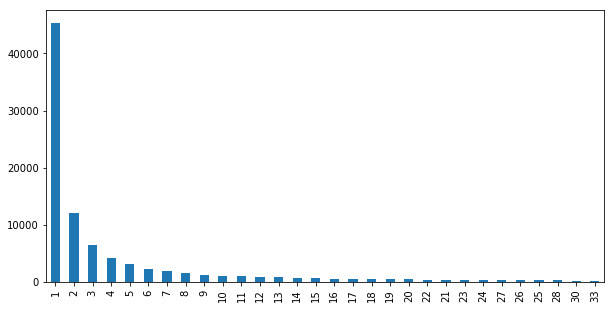

In [48]:
plt.figure(figsize=(10,5))
token_counts['count'].value_counts()[:30].plot(kind='bar')
plt.show()

## Baseline classification model
Because the matrix object-feature will be very sparse, you'll use the linear model -- logistic regression with l1-regularization.

In [12]:
#clf = SGDClassifier(loss='huber', n_jobs=12, n_iter=50)

In [8]:
clf = LogisticRegression(n_jobs=12, warm_start=True, penalty='l1')

## Confusion matrix

To watch any more/less model classes mistaken will build сonfusion matrix.

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f" % cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def cm_show(clf, X, y, title, classes=['1','2','3','4','5']):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
    y_pred = clf.fit(x_train, y_train).predict(x_test)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    #plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False, \
    #                      title=title)

    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title=title)
    plt.show()

## TF-IDF + N-grams
### Without Stopwords and punctuation

In [10]:
%%time 

train = texts_processing(train_data, punc=True, stopword=True)
test = texts_processing(test_data, punc=True, stopword=True)

CPU times: user 17 s, sys: 1.04 s, total: 18.1 s
Wall time: 18.1 s


**Pipeline**

In [11]:
text_clf = Pipeline([('vect', TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}')),\
                     ('clf', clf)])

parameters = {'vect__max_features': [15000, 30000, 60000]}

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=12, verbose=10)

In [12]:
%time gs_clf.fit(train, train_label)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] ......... vect__max_features=15000, score=0.577597, total= 2.5min
[CV] ......... vect__max_features=15000, score=0.575846, total= 2.5min


[Parallel(n_jobs=12)]: Done   2 out of   9 | elapsed:  3.0min remaining: 10.5min


[CV] ......... vect__max_features=15000, score=0.582534, total= 2.5min
[CV] ......... vect__max_features=30000, score=0.576632, total= 2.5min


[Parallel(n_jobs=12)]: Done   3 out of   9 | elapsed:  3.0min remaining:  6.0min
[Parallel(n_jobs=12)]: Done   4 out of   9 | elapsed:  3.0min remaining:  3.8min


[CV] ......... vect__max_features=30000, score=0.576256, total= 2.5min


[Parallel(n_jobs=12)]: Done   5 out of   9 | elapsed:  3.0min remaining:  2.4min


[CV] ......... vect__max_features=30000, score=0.582153, total= 2.5min


[Parallel(n_jobs=12)]: Done   6 out of   9 | elapsed:  3.0min remaining:  1.5min


[CV] ......... vect__max_features=60000, score=0.581276, total= 2.5min


[Parallel(n_jobs=12)]: Done   7 out of   9 | elapsed:  3.1min remaining:   52.7s


[CV] ......... vect__max_features=60000, score=0.576022, total= 2.5min
[CV] ......... vect__max_features=60000, score=0.576164, total= 2.6min


[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  3.1min finished


CPU times: user 3min, sys: 5.44 s, total: 3min 6s
Wall time: 6min 10s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...lty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True))]),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'vect__max_features': [15000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [13]:
print("Best score: %s \nParameters: %s" % (gs_clf.best_score_, gs_clf.best_params_))

Best score: 0.578658917148 
Parameters: {'vect__max_features': 15000}


**All text**

In [17]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=15000)
%time tfidf.fit(train + test)

CPU times: user 3min 7s, sys: 4.79 s, total: 3min 12s
Wall time: 3min 12s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=15000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
%time X_train = tfidf.transform(train)

CPU times: user 42.2 s, sys: 138 ms, total: 42.3 s
Wall time: 42.3 s


In [20]:
scores = cross_val_score(clf, X_train, train_label, cv=5, scoring='accuracy', n_jobs=12)
print("Mean score: %s \nStd: %s" % (np.mean(scores), np.std(scores)))

Mean score: 0.580589729296 
Std: 0.00101886651818


**Confusion matrix**

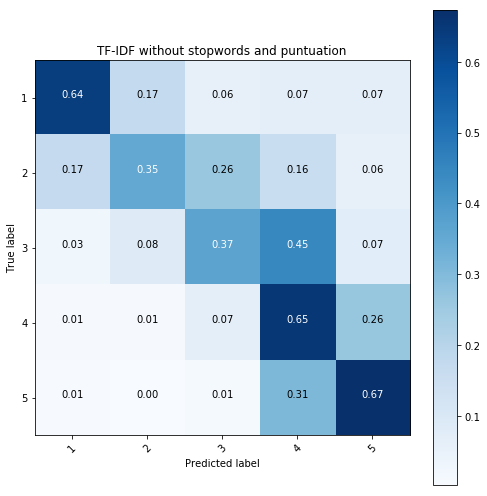

In [29]:
cm_show(clf, X_train, train_label, title='TF-IDF without stopwords and puntuation')

### With Stopwords 

In [31]:
text_clf = Pipeline([('vect', TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}')),
                     ('clf', clf)])

parameters = {'vect__max_features': [15000, 30000, 60000]}

gs_clf = GridSearchCV(text_clf, parameters, scoring='accuracy', n_jobs=12, verbose=10)

**Pipeline**

In [32]:
%time gs_clf.fit(train_data, train_label)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] ......... vect__max_features=30000, score=0.603341, total= 3.8min
[CV] ......... vect__max_features=15000, score=0.604652, total= 3.8min
[CV] ......... vect__max_features=15000, score=0.601586, total= 3.9min


[Parallel(n_jobs=12)]: Done   2 out of   9 | elapsed:  5.0min remaining: 17.4min
[Parallel(n_jobs=12)]: Done   3 out of   9 | elapsed:  5.0min remaining:  9.9min


[CV] ......... vect__max_features=60000, score=0.600860, total= 3.9min
[CV] ......... vect__max_features=15000, score=0.600246, total= 3.9min


[Parallel(n_jobs=12)]: Done   4 out of   9 | elapsed:  5.0min remaining:  6.3min
[Parallel(n_jobs=12)]: Done   5 out of   9 | elapsed:  5.0min remaining:  4.0min


[CV] ......... vect__max_features=60000, score=0.605998, total= 3.9min


[Parallel(n_jobs=12)]: Done   6 out of   9 | elapsed:  5.1min remaining:  2.5min


[CV] ......... vect__max_features=30000, score=0.606378, total= 4.0min


[Parallel(n_jobs=12)]: Done   7 out of   9 | elapsed:  5.1min remaining:  1.5min


[CV] ......... vect__max_features=60000, score=0.602229, total= 4.1min
[CV] ......... vect__max_features=30000, score=0.600772, total= 4.5min


[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  5.6min finished


CPU times: user 4min 35s, sys: 9.38 s, total: 4min 44s
Wall time: 10min 19s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...lty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True))]),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'vect__max_features': [15000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [33]:
print("Best score: %s \nParameters: %s" % (gs_clf.best_score_, gs_clf.best_params_))

Best score: 0.603497035419 
Parameters: {'vect__max_features': 30000}


**All text**

In [34]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=30000)
%time tfidf.fit(train_data + test_data)

CPU times: user 4min 4s, sys: 5.49 s, total: 4min 9s
Wall time: 4min 9s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

Transformation

In [35]:
%%time

X_train = tfidf.transform(train_data)
X_test = tfidf.transform(test_data)

CPU times: user 1min 54s, sys: 723 ms, total: 1min 55s
Wall time: 1min 55s


In [36]:
scores = cross_val_score(clf, X_train, train_label, cv=3, scoring='accuracy', n_jobs=10)
print("Mean score: %s \nStd: %s" % (np.mean(scores), np.std(scores)))

Mean score: 0.603584836901 
Std: 0.00226279594289


**Pickling**

In [37]:
######### Saving ##############

pickling_data('X_train_tfidf', X_train)
pickling_data('X_test_tfidf', X_test)

In [ ]:
######### Loading #############

# X_train_tfidf = load_data('X_train_tfidf')
# X_test_tfidf = load_data('X_test_tfidf')

**Confusion matrix**

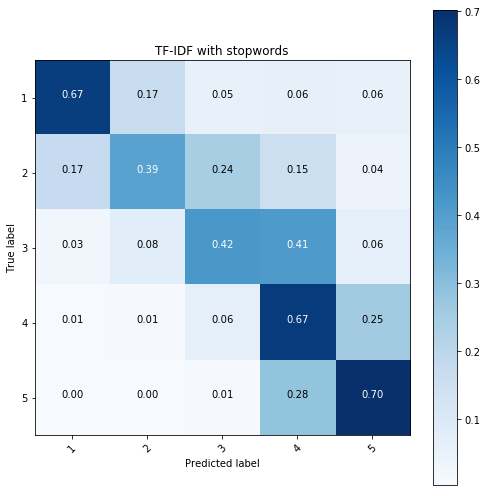

In [38]:
cm_show(clf, X_train, train_label, title='TF-IDF with stopwords')

## TF-IDF + N-grams + Lemmatization

In [48]:
def lemmatization_word(word):
    pos = ['a','v','n','r']
    lemmatizer = WordNetLemmatizer()
    for p in pos:
        temp = lemmatizer.lemmatize(word, p)
        if temp != word:
            return temp
    return word  

def lemmatization_texts(texts, punc=False, stopword=False):
    text_lemma = [[lemmatization_word(word) for word in tokenize_string(review, punc, stopword)] for review in texts]
    string_lemma = [' '.join(text) for text in text_lemma]
    return string_lemma

In [49]:
%time train_lemma = lemmatization_texts(train_data, punc=True)
print(train_lemma[1])

CPU times: user 8min 53s, sys: 5.11 s, total: 8min 58s
Wall time: 8min 58s
i m not really sure what just happen to me i just eat a bunch of flash freeze meat that be white curl and stiff i put it in a bowl and mash it with a napkin put some even le fresh look veggie on it and hand it to an angry mexican who proceed to cook it on something that look like the urinal in sun devil stadium i didn t like prepare my own food for this price i don t like that they know the meat shrink but win t give you a decent size bowl to put enough in it although with a nasty a the meat taste why would you want any more of it i might go back here and just do noodle and sauce the noodle be the only thing that seem safe to eat and the sauce you make your own be the only thing redeem about this place i be definitely miss the wendy s that use to be in this spot


In [50]:
%time test_lemma = lemmatization_texts(test_data, punc=True)

CPU times: user 2min 55s, sys: 1.86 s, total: 2min 57s
Wall time: 2min 57s


In [51]:
%time gs_clf.fit(train_lemma, train_label)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] ......... vect__max_features=15000, score=0.595904, total= 3.8min
[CV] ......... vect__max_features=30000, score=0.598537, total= 3.7min


[Parallel(n_jobs=12)]: Done   2 out of   9 | elapsed:  5.1min remaining: 17.9min


[CV] ......... vect__max_features=30000, score=0.592434, total= 4.2min


[Parallel(n_jobs=12)]: Done   3 out of   9 | elapsed:  6.0min remaining: 12.0min


[CV] ......... vect__max_features=30000, score=0.596057, total= 5.3min


[Parallel(n_jobs=12)]: Done   4 out of   9 | elapsed:  6.3min remaining:  7.9min


[CV] ......... vect__max_features=60000, score=0.597484, total= 5.2min


[Parallel(n_jobs=12)]: Done   5 out of   9 | elapsed:  6.3min remaining:  5.1min


[CV] ......... vect__max_features=15000, score=0.596378, total= 5.5min


[Parallel(n_jobs=12)]: Done   6 out of   9 | elapsed:  6.5min remaining:  3.3min


[CV] ......... vect__max_features=15000, score=0.593488, total= 5.5min


[Parallel(n_jobs=12)]: Done   7 out of   9 | elapsed:  6.6min remaining:  1.9min


[CV] ......... vect__max_features=60000, score=0.594886, total= 5.6min
[CV] ......... vect__max_features=60000, score=0.591352, total= 6.0min


[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  7.0min finished


CPU times: user 4min 22s, sys: 8.75 s, total: 4min 31s
Wall time: 11min 32s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...lty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True))]),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'vect__max_features': [15000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [53]:
print("Best score: %s \nParameters: %s" % (gs_clf.best_score_, gs_clf.best_params_))

Best score: 0.595676002496 
Parameters: {'vect__max_features': 30000}


**All text**

In [54]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=30000)
%time tfidf.fit(train_lemma + test_lemma)

CPU times: user 3min 51s, sys: 5.16 s, total: 3min 56s
Wall time: 3min 56s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [55]:
%time X_train = tfidf.transform(train_lemma)
#%time X_test = tfidf.transform(test_lemma)

CPU times: user 1min 26s, sys: 675 ms, total: 1min 27s
Wall time: 1min 27s


In [56]:
scores = cross_val_score(clf, X_train, train_label, cv=3, scoring='accuracy', n_jobs=10)
print("Mean score: %s \nStd: %s" % (np.mean(scores), np.std(scores)))

Mean score: 0.595773555309 
Std: 0.00227271866777


**Confusion matrix**

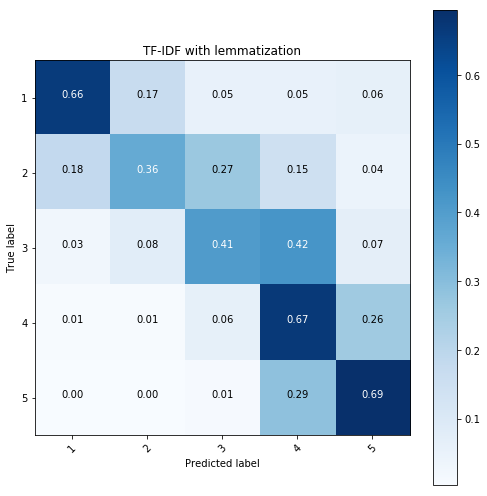

In [57]:
cm_show(clf, X_train, train_label, title='TF-IDF with lemmatization')

## Mark negation
For more detials see [nltk.sentiment package](http://www.nltk.org/api/nltk.sentiment.html)

In [63]:
def mark_negation_texts(texts, lemma=False, stopword=False):
    
    if stopword:
        filtered_text = texts_processing(texts, stopword=stopword) 
        all_tokens = [text.split() for text in filtered_text]
    else:
        all_tokens = [text.split() for text in texts_processing(texts)]
    
    if lemma:
        reviews = [[lemmatization_word(word) for word in tokens] for tokens in all_tokens]
    else:
        reviews = all_tokens
    
    mark = [' '.join(mark_negation(review)) for review in reviews]
    return mark

In [64]:
%time train_neg = mark_negation_texts(train_data)
%time test_neg = mark_negation_texts(test_data)
print(train_neg[1])

CPU times: user 6min 42s, sys: 5.09 s, total: 6min 47s
Wall time: 6min 47s
CPU times: user 2min 13s, sys: 656 ms, total: 2min 13s
Wall time: 2min 16s
i 'm not really_NEG sure_NEG what_NEG just_NEG happened_NEG to_NEG me_NEG . i just ate a bunch of flash-frozen meat that was white , curled , and stiff . i put it in a bowl and mashed it with a napkin , put some even less fresh looking veggies on it , and handed it to an angry mexican who proceeded to cook it on something that looked like the urinals in sun devil stadium . i did n't like_NEG preparing_NEG my_NEG own_NEG food_NEG for_NEG this_NEG price_NEG ,_NEG i_NEG do_NEG n't_NEG like_NEG that_NEG they_NEG know_NEG the_NEG meat_NEG shrinks_NEG but_NEG wo_NEG n't_NEG give_NEG you_NEG a_NEG decent_NEG sized_NEG bowl_NEG to_NEG put_NEG enough_NEG in_NEG it_NEG -_NEG although_NEG ..._NEG with_NEG as_NEG nasty_NEG as_NEG the_NEG meat_NEG tasted_NEG ,_NEG why_NEG would_NEG you_NEG want_NEG any_NEG more_NEG of_NEG it_NEG ? i might go back here

**Pipeline**

In [65]:
%time gs_clf.fit(train_neg, train_label)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=15000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=30000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] vect__max_features=60000 ........................................
[CV] ......... vect__max_features=15000, score=0.598315, total= 4.1min
[CV] ......... vect__max_features=15000, score=0.600152, total= 4.1min


[Parallel(n_jobs=12)]: Done   2 out of   9 | elapsed:  5.2min remaining: 18.2min


[CV] ......... vect__max_features=30000, score=0.600012, total= 4.1min


[Parallel(n_jobs=12)]: Done   3 out of   9 | elapsed:  5.2min remaining: 10.4min


[CV] ......... vect__max_features=30000, score=0.605471, total= 4.2min


[Parallel(n_jobs=12)]: Done   4 out of   9 | elapsed:  5.3min remaining:  6.6min


[CV] ......... vect__max_features=15000, score=0.604593, total= 4.3min


[Parallel(n_jobs=12)]: Done   5 out of   9 | elapsed:  5.3min remaining:  4.3min


[CV] ......... vect__max_features=60000, score=0.606261, total= 4.2min


[Parallel(n_jobs=12)]: Done   6 out of   9 | elapsed:  5.4min remaining:  2.7min


[CV] ......... vect__max_features=60000, score=0.599076, total= 4.2min


[Parallel(n_jobs=12)]: Done   7 out of   9 | elapsed:  5.4min remaining:  1.5min


[CV] ......... vect__max_features=60000, score=0.601703, total= 4.2min
[CV] ......... vect__max_features=30000, score=0.601118, total= 4.4min


[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   9 out of   9 | elapsed:  5.5min finished


CPU times: user 4min 46s, sys: 12.2 s, total: 4min 58s
Wall time: 10min 23s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
  ...lty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True))]),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'vect__max_features': [15000, 30000, 60000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [66]:
print("Best score: %s \nParameters: %s" % (gs_clf.best_score_, gs_clf.best_params_))

Best score: 0.602346309877 
Parameters: {'vect__max_features': 60000}


**All text**

In [71]:
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=30000)
%time tfidf.fit(train_neg + test_neg)

CPU times: user 4min 28s, sys: 7.14 s, total: 4min 35s
Wall time: 4min 35s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [72]:
%time X_train_neg = tfidf.transform(train_neg)
%time X_test_neg = tfidf.transform(test_neg)

CPU times: user 1min 33s, sys: 784 ms, total: 1min 34s
Wall time: 1min 34s
CPU times: user 30.4 s, sys: 195 ms, total: 30.6 s
Wall time: 30.6 s


In [73]:
scores = cross_val_score(clf, X_train, train_label, cv=3, scoring='accuracy', n_jobs=10)
print("Mean score: %s \nStd: %s" % (np.mean(scores), np.std(scores)))

Mean score: 0.595783305319 
Std: 0.00221048155807


**Confusion matrix**

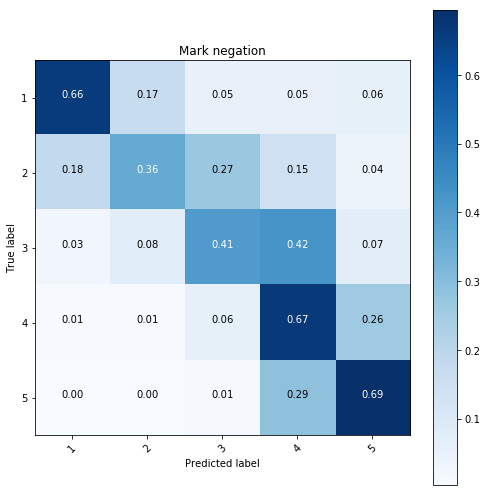

In [74]:
cm_show(clf, X_train, train_label, title='Mark negation')

## TF-IDF + N-chars
Now let's try to set features using character-based approach. Perhaps it will turn out to catch a syntactic relation words.
### With Stopwords and Punctuation

In [75]:
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2,5), max_features=50000)
%time tfidf_char.fit(train_data + test_data)

CPU times: user 10min 21s, sys: 9.91 s, total: 10min 31s
Wall time: 10min 34s


TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(2, 5), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [76]:
%time X_train_char = tfidf_char.transform(train_data)

CPU times: user 7min 26s, sys: 4.67 s, total: 7min 31s
Wall time: 7min 31s


In [77]:
%time X_test_char = tfidf_char.transform(test_data)

CPU times: user 2min 26s, sys: 1.48 s, total: 2min 27s
Wall time: 2min 27s


In [78]:
scores = cross_val_score(clf, X_train_char, train_label, cv=3, scoring='accuracy', n_jobs=12, verbose=10)
print("Mean score: %.3f \nStandart deviation: %.3f" %(np.mean(scores), np.std(scores)))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.584126, total= 3.8min
[CV] ................................. , score=0.583623, total= 4.0min
[CV] ................................. , score=0.586922, total= 4.0min


[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:  4.4min finished


Mean score: 0.585 
Standart deviation: 0.001


In [79]:
#import operator
#sorted_x = sorted(tfidf_char.vocabulary_.items(), key=operator.itemgetter(1))

**Pickling**

In [80]:
######### Saving ##############

pickling_data('X_train_char', X_train_char)
pickling_data('X_test_char', X_test_char)

In [ ]:
######### Loading #############

# X_train_char = load_data('X_train_char')
# X_test_char = load_data('X_test_char')

**Confusion matrix**

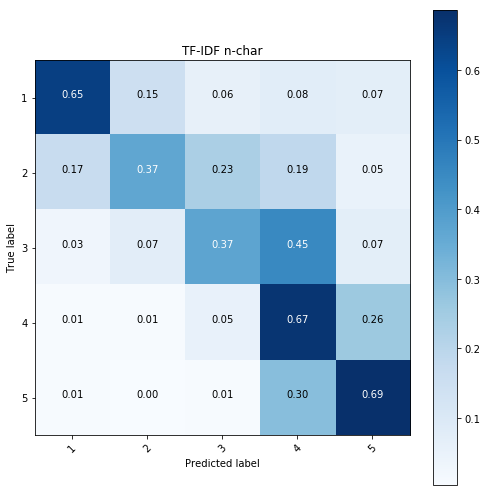

In [82]:
cm_show(clf, X_train_char, train_label, title='TF-IDF n-char')

## N-grams + N-chars
Concatenating matrix obtained when using different approaches

In [11]:
######### Loading #############

X_train_tfidf = load_data('X_train_tfidf')
X_test_tfidf = load_data('X_test_tfidf')
X_train_char = load_data('X_train_char')
X_test_char = load_data('X_test_char')

In [12]:
%%time

X_TRAIN = sparse.hstack([X_train_tfidf, X_train_char])
X_TEST = sparse.hstack([X_test_tfidf, X_test_char])

CPU times: user 8.12 s, sys: 3.71 s, total: 11.8 s
Wall time: 11.8 s


In [12]:
scores = cross_val_score(clf, X_TRAIN, train_label, cv=3, scoring='accuracy', n_jobs=12, verbose=10)
print("Mean score: %.3f \nStandart deviation: %.3f" %(np.mean(scores), np.std(scores)))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................. , score=0.605944, total= 3.8min
[CV] ................................. , score=0.607753, total= 3.6min
[CV] ................................. , score=0.603815, total= 4.3min


[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:  4.5min finished


Mean score: 0.606 
Standart deviation: 0.002


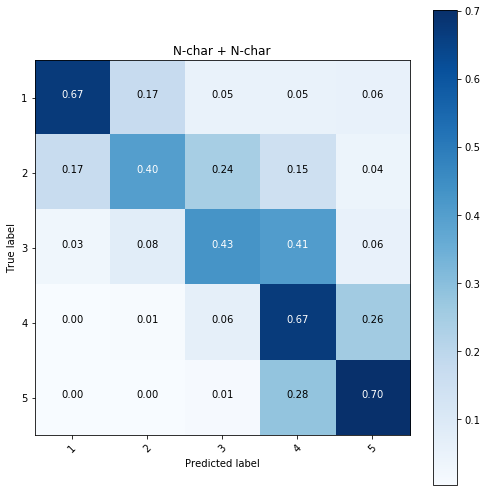

In [13]:
cm_show(clf, X_TRAIN, train_label, title='N-char + N-char')

### Multinomial Naïve Bayes

In [13]:
nb = MultinomialNB()
param_grid = {'alpha':[0, 1],
              'fit_prior': [True, False]}

gs = GridSearchCV(nb, param_grid, scoring='accuracy', n_jobs=12, cv=5, verbose=10)

In [14]:
gs.fit(X_TRAIN, train_label)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] fit_prior=True, alpha=0 .........................................
[CV] fit_prior=True, alpha=0 .........................................
[CV] fit_prior=True, alpha=0 .........................................
[CV] .......... fit_prior=True, alpha=0, score=0.560772, total=  11.9s
[CV] fit_prior=True, alpha=0 .........................................
[CV] .......... fit_prior=True, alpha=0, score=0.560919, total=  11.7s
[CV] fit_prior=True, alpha=0 .........................................
[CV] .......... fit_prior=True, alpha=0, score=0.562854, total=  11.8s


[Parallel(n_jobs=12)]: Done   3 out of  20 | elapsed:   35.0s remaining:  3.3min


[CV] fit_prior=False, alpha=0 ........................................
[CV] .......... fit_prior=True, alpha=0, score=0.565319, total=  11.4s
[CV] fit_prior=False, alpha=0 ........................................
[CV] .......... fit_prior=True, alpha=0, score=0.565124, total=  12.0s
[CV] fit_prior=False, alpha=0 ........................................
[CV] ......... fit_prior=False, alpha=0, score=0.548974, total=  12.0s


[Parallel(n_jobs=12)]: Done   6 out of  20 | elapsed:   54.1s remaining:  2.1min


[CV] fit_prior=False, alpha=0 ........................................
[CV] ......... fit_prior=False, alpha=0, score=0.547072, total=  11.9s
[CV] fit_prior=False, alpha=0 ........................................
[CV] ......... fit_prior=False, alpha=0, score=0.546372, total=  11.9s
[CV] fit_prior=True, alpha=1 .........................................
[CV] ......... fit_prior=False, alpha=0, score=0.552397, total=  11.7s


[Parallel(n_jobs=12)]: Done   9 out of  20 | elapsed:  1.2min remaining:  1.5min


[CV] fit_prior=True, alpha=1 .........................................
[CV] ......... fit_prior=False, alpha=0, score=0.548837, total=  12.4s
[CV] fit_prior=True, alpha=1 .........................................
[CV] .......... fit_prior=True, alpha=1, score=0.558042, total=  12.0s
[CV] fit_prior=True, alpha=1 .........................................
[CV] .......... fit_prior=True, alpha=1, score=0.555702, total=  11.8s


[Parallel(n_jobs=12)]: Done  12 out of  20 | elapsed:  1.5min remaining:  1.0min


[CV] fit_prior=True, alpha=1 .........................................
[CV] .......... fit_prior=True, alpha=1, score=0.558904, total=  11.2s
[CV] fit_prior=False, alpha=1 ........................................
[CV] .......... fit_prior=True, alpha=1, score=0.562393, total=  11.8s
[CV] fit_prior=False, alpha=1 ........................................
[CV] .......... fit_prior=True, alpha=1, score=0.562735, total=  11.7s


[Parallel(n_jobs=12)]: Done  15 out of  20 | elapsed:  1.8min remaining:   36.9s


[CV] fit_prior=False, alpha=1 ........................................
[CV] ......... fit_prior=False, alpha=1, score=0.551948, total=  11.1s
[CV] fit_prior=False, alpha=1 ........................................
[CV] ......... fit_prior=False, alpha=1, score=0.550729, total=  11.6s
[CV] fit_prior=False, alpha=1 ........................................
[CV] ......... fit_prior=False, alpha=1, score=0.551687, total=  11.7s


[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:  2.2min remaining:   14.4s


[CV] ......... fit_prior=False, alpha=1, score=0.550641, total=  11.4s
[CV] ......... fit_prior=False, alpha=1, score=0.552153, total=  11.1s


[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'fit_prior': [True, False], 'alpha': [0, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [15]:
nb = gs.best_estimator_

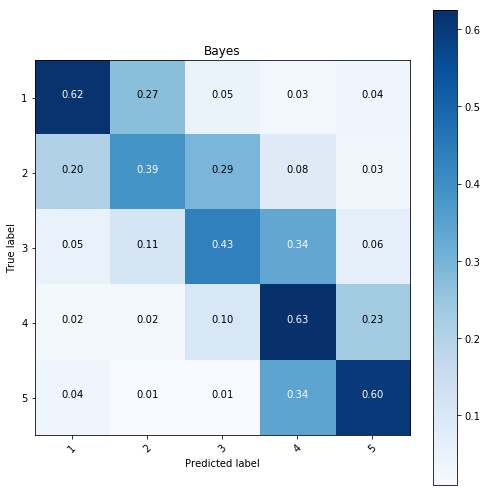

In [16]:
cm_show(nb, X_TRAIN, train_label, title='Bayes', classes=['1','2','3','4','5'])

## Prediction

In [23]:
lr = LogisticRegression(n_jobs=12, penalty='l1', verbose=10)
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=12,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=10, warm_start=False)


In [24]:
%time lr.fit(X_TRAIN, train_label)

[LibLinear]CPU times: user 5min 41s, sys: 10.7 s, total: 5min 52s
Wall time: 5min 52s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=12,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=10, warm_start=False)

In [25]:
y_test = lr.predict(X_TEST)
sol = pd.DataFrame(np.array([test_id, y_test]).transpose(), columns=['ID','Sentiment'])
sol.to_csv('solution.csv', index=False)

In [26]:
df = pd.read_csv('solution.csv')

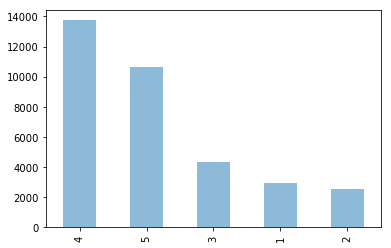

In [27]:
df.Sentiment.value_counts().plot(kind='bar', alpha=0.5)